# Linear Regression

## Introduction

In this file, we will be focusing on the linear regression analysis of how the pct_change in Bitcoin's price (btc_price_chg) is related to the Ethereum's price (eth_price_chg) and/or Litecoin's price (ltc_price_chg).

As expected, we can see the relationship between btc_price_chg (explanatory variable x) and eth_price_chg and ltc_price_chg (target variable y) in a same day. It is just the same day's relationship between different currencies, such that our findings does not mean "the prediction of tomorrow". However, we could obtain the sensitivity of btc_price_chg to eth and ltc_price_changes, the model which can work in test data as well. Therefore, we could utilize our findings such as following:

*  When the daily bitcoin price increased sharply while eth and ltc increased very little, i.e. less than β times btc_price_chg, we can buy eth and ltc and can sell eth and ltc when those price reaches around β times btc_price_chg.

*  When the daily bitcoin price decreased modelately while eth and ltc decreased sharpely, i.e. more than β times btc_price_chg, we can buy eth and ltc and can sell eth and ltc when those price reaches around β times btc_price_chg.



In [1]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/IT5006/FinalPackage'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/IT5006/FinalPackage']


## Data Setup

### Import Libaries 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import array
import datetime
import random
from dateutil.parser import parse
from pylab import rcParams

In [3]:
import warnings
warnings.filterwarnings('ignore')
# Here we are trying to set the float data's to 8 decimal place, same as that of a bitcoin
pd.options.display.float_format = '{:.4f}'.format

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

### Load Dataset and Data preparation

In [5]:
main_df = pd.read_csv("./team12_cleandata.csv")
main_df.describe()
del main_df['Unnamed: 0']

In [6]:
main_df.tail()

,day,btc_price,btc_mktcap,btc_volume,eth_price,eth_mktcap,eth_volume,xrp_price,xrp_mktcap,xrp_volume,ltc_price,ltc_mktcap,ltc_volume,btc_price_chg,btc_mktcap_chg,btc_volume_chg,eth_price_chg,eth_mktcap_chg,eth_volume_chg,xrp_price_chg,xrp_mktcap_chg,xrp_volume_chg,ltc_price_chg,ltc_mktcap_chg,ltc_volume_chg,btc_vol20d,eth_vol20d,xrp_vol20d,ltc_vol20d,btc_vol60d,eth_vol60d,xrp_vol60d,ltc_vol60d,btc_SMA10d,eth_SMA10d,xrp_SMA10d,ltc_SMA10d,btc_SMA50d,eth_SMA50d,xrp_SMA50d,...,spx_SMA50d,ndx_SMA50d,gold_SMA50d,us10y_SMA50d,dxy_SMA50d,spx_SMA100d,ndx_SMA100d,gold_SMA100d,us10y_SMA100d,dxy_SMA100d,spx_SMA200d,ndx_SMA200d,gold_SMA200d,us10y_SMA200d,dxy_SMA200d,spx_DiffSMA10d,ndx_DiffSMA10d,gold_DiffSMA10d,us10y_DiffSMA10d,dxy_DiffSMA10d,spx_DiffSMA50d,ndx_DiffSMA50d,gold_DiffSMA50d,us10y_DiffSMA50d,dxy_DiffSMA50d,spx_DiffSMA100d,ndx_DiffSMA100d,gold_DiffSMA100d,us10y_DiffSMA100d,dxy_DiffSMA100d,spx_DiffSMA200d,ndx_DiffSMA200d,gold_DiffSMA200d,us10y_DiffSMA200d,dxy_DiffSMA200d,spx_RSI,ndx_RSI,gold_RSI,us10y_RSI,dxy_RSI
2400,2020-12-27,26476.1301,491978602969.9318,41995154622.7405,636.7423,72391403990.8806,14640527408.4817,0.2954,13418021942.6170,7431667092.9127,129.7577,8586987927.7796,8927412003.2652,0.0732,0.0732,0.1467,0.0164,0.0136,0.1154,-0.0714,-0.0476,-0.4350,0.0218,0.0219,0.0860,0.5787,0.6235,2.2142,1.1832,0.5520,0.6605,1.8632,1.0334,23815.9837,630.6764,0.4486,113.6752,19124.4086,556.5606,0.4642,...,3601.1830,12187.6650,1861.5510,0.9008,91.7204,3493.8100,11816.5850,1886.3520,0.8164,92.5667,3331.8493,11100.1612,1854.5880,0.7431,94.3391,0.0000,0.0004,-0.0005,-0.0021,0.0016,0.0261,0.0424,0.0072,0.0435,-0.0143,0.0576,0.0751,-0.0060,0.1514,-0.0233,0.1090,0.1445,0.0110,0.2650,-0.0416,60.2001,64.8316,56.0864,54.5412,39.3511
2401,2020-12-28,26423.2288,493427450341.2601,56654980595.9309,689.6599,78833072066.0927,24721301579.8804,0.2841,13068762432.4132,7010555503.5593,127.8991,8553327960.2345,10006162991.7788,-0.0020,0.0029,0.3491,0.0831,0.0890,0.6886,-0.0380,-0.0260,-0.0567,-0.0143,-0.0039,0.1208,0.5765,0.6791,2.2143,1.1889,0.5468,0.6711,1.8644,1.0299,24177.7410,635.2359,0.4194,116.2782,19356.5040,561.6454,0.4649,...,3610.4380,12223.3950,1861.4140,0.9020,91.6464,3495.2925,11820.7975,1885.6315,0.8192,92.5416,3335.8448,11118.2337,1855.4427,0.7443,94.2921,0.0079,0.0091,-0.0017,-0.0042,0.0010,0.0324,0.0499,0.0073,0.0421,-0.0143,0.0664,0.0856,-0.0056,0.1475,-0.0238,0.1174,0.1542,0.0105,0.2628,-0.0419,66.9432,70.2103,56.0864,54.5412,38.0935
2402,2020-12-29,27125.3841,503712223153.6673,42186521237.4668,732.9570,83575563402.6638,22707049400.1432,0.2461,11125026065.8103,5788819181.4235,130.6387,8661848120.1502,7456439915.5011,0.0266,0.0208,-0.2554,0.0628,0.0602,-0.0815,-0.1338,-0.1487,-0.1743,0.0214,0.0127,-0.2548,0.5291,0.6476,2.2395,1.1223,0.5476,0.6787,1.8867,1.0273,24578.2223,643.0895,0.3857,118.4406,19589.0854,567.1974,0.4647,...,3619.5410,12259.2900,1861.2630,0.9032,91.5658,3497.8765,11831.2025,1884.9700,0.8223,92.5143,3339.8023,11136.3475,1856.2940,0.7456,94.2435,0.0057,0.0091,-0.0012,-0.0042,-0.0029,0.0277,0.0475,0.0070,0.0407,-0.0170,0.0635,0.0854,-0.0057,0.1431,-0.0271,0.1138,0.1531,0.0097,0.2607,-0.0449,64.2039,70.5227,55.7074,54.5412,32.7764
2403,2020-12-30,27424.5390,509680257177.0481,38081840205.6021,735.5909,83885243123.8154,17170428247.7612,0.2214,10057607712.3322,10590299229.5117,129.6282,8581202273.4574,5810649636.6047,0.0110,0.0118,-0.0973,0.0036,0.0037,-0.2438,-0.1005,-0.0959,0.8294,-0.0077,-0.0093,-0.2207,0.5294,0.6441,2.2362,1.1277,0.5475,0.6775,1.8991,1.0262,24934.2907,650.7168,0.3499,119.3390,19830.8693,573.0082,0.4642,...,3628.0150,12294.8550,1861.2170,0.9044,91.4774,3500.9435,11844.1300,1884.5830,0.8244,92.4826,3343.8095,11154.1600,1857.2182,0.7466,94.1905,0.0063,0.0081,0.0054,-0.0127,-0.0067,0.0265,0.0445,0.0142,0.0283,-0.0202,0.0638,0.0842,0.0016,0.1281,-0.0308,0.1138,0.1513,0.0164,0.2456,-0.0484,65.0747,70.5428,61.0872,51.5968,27.9400
2404,2020-12-31,28837.2885,535967306917.8413,43341140482.2822,752.8559,8579017802

In [7]:
#converting column 'day' as datetime from object.
main_df['day'] = pd.to_datetime(main_df['day'], format="%Y-%m-%d")

In [8]:
#Taking only relevant data from whole dataset, implementing ffill, and describe basic data.
close_px = main_df[['day', 'btc_price_chg', 'eth_price_chg', 'ltc_price_chg']]
close_px = close_px.ffill()
close_px.describe()

,btc_price_chg,eth_price_chg,ltc_price_chg
count,2404.0000,1691.0000,2404.0000
mean,0.0027,0.0049,0.0025
std,0.0417,0.0648,0.0662
min,-0.3519,-0.4833,-0.4214
25%,-0.0126,-0.0233,-0.0220
50%,0.0021,-0.0004,-0.0014
75%,0.0183,0.0293,0.0194
max,0.3326,0.5524,0.9325


In [9]:
close_px.dropna()

,day,btc_price_chg,eth_price_chg,ltc_price_chg
714,2015-08-09,0.0175,0.0000,-0.0045
715,2015-08-10,-0.0029,-0.4833,0.0096
716,2015-08-11,0.0239,0.5524,0.0478
717,2015-08-12,-0.0080,0.1773,-0.0155
718,2015-08-13,-0.0152,0.4526,-0.0422
...,...,...,...,...
2400,2020-12-27,0.0732,0.0164,0.0218
2401,2020-12-28,-0.0020,0.0831,-0.0143
2402,2020-12-29,0.0266,0.0628,0.0214
2403,2020-12-30,0.0110,0.0036,-0.0077


### Data visualization with scatter plot with Kernel Density Estimate

We can see here the distribution of pct_change in our datas and we can also see the positive correlation among the digital assets, the results which was seen in the heat map of our milestone 1 project). Also we can see that btc has the price percentage change centered around 0, with value of about 0.3 of the distribution while eth and ltc are at >0.4 and >0.8 respectively. Providing us the difference in volatility with better numerics and visualization.

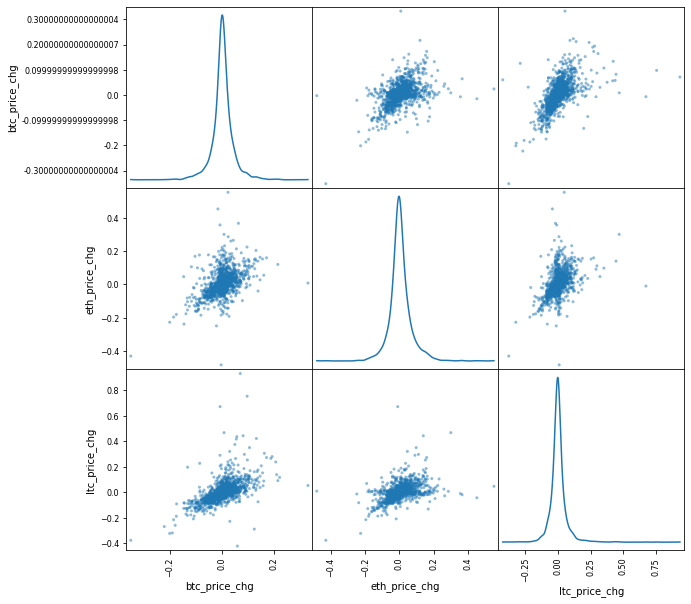

In [10]:
pd.plotting.scatter_matrix(close_px, diagonal='kde', figsize=(10, 10));

## Modeling and prediction

### ETH prediction

Below shows whole steps of linear regression modeling. Observation is shown as follows:

*  R-square is not much high, 0.221.
*  Regression coefficient of btc_price_chg is 0.772. This means that, on average, when btc_price_chg is +1%, eth_price_chg can move by +0.772%.
*  On the other hands, regarding the btc_price_chg coefficient, t-stat is very high with 19.582 and p-value is very low, nearly zero.
*  Also, F-statistic is high 383.5, such that prob(F-stat) is very low.
*  Regarding residual plot, while we observe some outliers such that the line is not straight, we can see that the line is totally horizontal around the points where many data is available (around -0.15 < btc_price_chg < +0.15).
*  About the prediction performance in test dataset, while we see some outliers, many test dataset can fall between upper and lower 95% confidence interval.

From above observations, we can conclude that our model can predict one day's y=eth_price_chg from x=btc_price_changes on a same day.

As we mentioned at the executive summary, it is just the same day's relationship between different currencies and our findings does not mean "the prediction for tomorrow". However, we could obtain the sensitivity of btc_price_chg to eth and ltc_price_changes by our regressions. Therefore, we could utilize our findings for intra-day trading such as following:

*  When the daily bitcoin price increased sharply while eth increased very little, i.e. less than 0.772 times btc_price_chg, we can buy eth. Then, we can sell eth when those price reaches around 0.772 times btc_price_chg.

*  When the daily bitcoin price decreased modelately while eth decreased sharpely, i.e. more than 0.772*btc_price_chg, we can buy eth. Then, we can sell eth when those price reaches around 0.772 times btc_price_chg.

#### Data preparation

In [11]:
#data preparation.
btc_eth_df = close_px.copy(deep=True)
btc_eth_df = btc_eth_df.dropna()
btc_eth_df = btc_eth_df.drop(['ltc_price_chg'], axis=1)
btc_eth_df.describe()

,btc_price_chg,eth_price_chg
count,1691.0000,1691.0000
mean,0.0029,0.0049
std,0.0395,0.0648
min,-0.3519,-0.4833
25%,-0.0105,-0.0233
50%,0.0022,-0.0004
75%,0.0178,0.0293
max,0.3326,0.5524


In [12]:
#train-test split. This time, we set 80/20.
X_train, X_test, y_train, y_test = train_test_split(
    btc_eth_df['btc_price_chg'], btc_eth_df['eth_price_chg'], 
    random_state=0, test_size=0.2)

In [13]:
train_set = pd.DataFrame([X_train,y_train]).T
test_set = pd.DataFrame([X_test,y_test]).T

In [14]:
print(train_set.shape)
print(test_set.shape)

(1352, 2)
(339, 2)


#### Modeling and residual plot

Our findings:

*  R-square is not much high, 0.221.
*  Regression coefficient of btc_price_chg is 0.772. This means that, on average, when btc_price_chg is +1%, eth_price_chg can move by +0.772%.
*  On the other hands, regarding the btc_price_chg coefficient, t-stat is very high with 19.582 and p-value is very low, nearly zero.
*  Also, F-statistic is high 383.5, such that prob(F-stat) is very low.

In [15]:
#modeling
lr_model_eth = smf.ols('eth_price_chg ~ btc_price_chg', data = train_set).fit()
print(lr_model_eth.summary())

                            OLS Regression Results                            
Dep. Variable:          eth_price_chg   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     383.5
Date:                Wed, 21 Apr 2021   Prob (F-statistic):           2.35e-75
Time:                        10:59:13   Log-Likelihood:                 1941.9
No. Observations:                1352   AIC:                            -3880.
Df Residuals:                    1350   BIC:                            -3869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0026      0.002      1.635

Our findings in residual plot:

*  Regarding residual plot, while we observe some outliers such that the line is not straight, we can see that the line is totally horizontal around the points where many data is available (around -0.15 < btc_price_chg < +0.15).

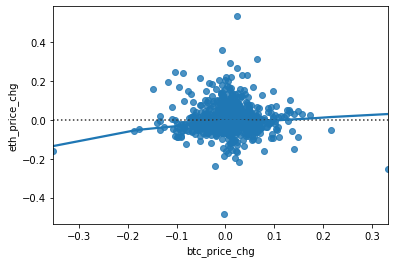

In [16]:
#residual plot.
sns.residplot(train_set['btc_price_chg'], train_set['eth_price_chg'], lowess=True, order=1)

#### Predictions

Our findings in predictions:
*  About the prediction performance in test dataset, while we see some outliers, many test dataset can fall between upper and lower 95% confidence interval.

In [17]:
#get upper and lower 95% of prediction.
std, upper,lower = wls_prediction_std(lr_model_eth)

In [18]:
y_pred = lr_model_eth.predict(test_set['btc_price_chg'])

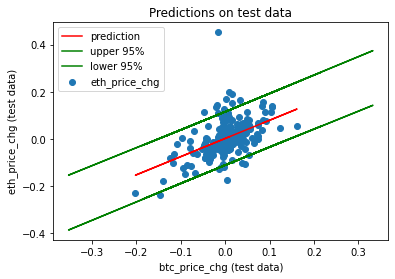

In [19]:
plt.scatter(x= 'btc_price_chg', y = 'eth_price_chg', data=test_set)
plt.plot(test_set['btc_price_chg'], y_pred, color='red', label='prediction')
plt.plot(train_set['btc_price_chg'], upper, color='green', label='upper 95%')
plt.plot(train_set['btc_price_chg'], lower, color='green', label='lower 95%')
plt.title("Predictions on test data")
plt.legend()
plt.xlabel("btc_price_chg (test data)")
plt.ylabel("eth_price_chg (test data)")
plt.show()

### LTC Prediction

Below shows whole steps of linear regression modeling. Observation is shown as follows:

*  R-square is higher than that in case of eth, 0.403.
*  Regression coefficient of btc_price_chg is 0.9024. This means that, on average, when btc_price_chg is +1%, eth_price_chg can move by +0.902%.
*  On the other hands, regarding the btc_price_chg coefficient, t-stat is very high with 30.17 and p-value is very low, nearly zero.
*  Also, F-statistic is high 910.2, which is higher than the case in eth, such that prob(F-stat) is very low.
*  Regarding residual plot, while we observe some outliers such that the line is not straight, we can see that the line is totally horizontal.
*  About the prediction performance in test dataset, while we see some outliers, many test dataset can fall between upper and lower 95% confidence interval. 95% confidence interval is narrower than that of eth case. Also, it can fit to test data nicer than the case in eth.

From above observations, we can conclude that our model can predict one day's y=ltc_price_chg from x=btc_price_changes on a same day.

As we mentioned at the executive summary, it is just the same day's relationship between different currencies and our findings does not mean "the prediction for tomorrow". However, we could obtain the sensitivity of btc_price_chg to ltc and ltc_price_changes by our regressions. Therefore, we could utilize our findings for intra-day trading such as following:

*  When the daily bitcoin price increased sharply while ltc increased very little, i.e. less than 0.9024 times btc_price_chg, we can buy ltc. Then, we can sell ltc when those price reaches around 0.9024 times btc_price_chg.

*  When the daily bitcoin price decreased modelately while ltc decreased sharpely, i.e. more than 0.9024*btc_price_chg, we can buy eth. Then, we can sell ltc when those price reaches around 0.9024 times btc_price_chg.

#### Data preparation

In [20]:
#data preparation.
btc_ltc_df = close_px.copy(deep=True)
btc_ltc_df = btc_ltc_df.dropna()
btc_ltc_df = btc_ltc_df.drop(['eth_price_chg'], axis=1)
btc_ltc_df.describe()

,btc_price_chg,ltc_price_chg
count,1691.0000,1691.0000
mean,0.0029,0.0020
std,0.0395,0.0569
min,-0.3519,-0.3759
25%,-0.0105,-0.0210
50%,0.0022,-0.0010
75%,0.0178,0.0200
max,0.3326,0.6726


In [21]:
#train-test split. This time, we set 80/20.
X_train_ltc, X_test_ltc, y_train_ltc, y_test_ltc = train_test_split(
    btc_ltc_df['btc_price_chg'], btc_ltc_df['ltc_price_chg'], 
    random_state=0, test_size=0.2)

In [22]:
train_set_ltc = pd.DataFrame([X_train_ltc,y_train_ltc]).T
test_set_ltc = pd.DataFrame([X_test_ltc,y_test_ltc]).T

In [23]:
print(train_set_ltc.shape)
print(test_set_ltc.shape)

(1352, 2)
(339, 2)


#### Modeling and residual plot

*  R-square is higher than that in case of eth, 0.403.
*  Regression coefficient of btc_price_chg is 0.9024. This means that, on average, when btc_price_chg is +1%, eth_price_chg can move by +0.902%.
*  On the other hands, regarding the btc_price_chg coefficient, t-stat is very high with 30.17 and p-value is very low, nearly zero.
*  Also, F-statistic is high 910.2, which is higher than the case in eth, such that prob(F-stat) is very low.

In [24]:
#modeling
lr_model_ltc = smf.ols('ltc_price_chg ~ btc_price_chg', data = train_set_ltc).fit()
print(lr_model_ltc.summary())

                            OLS Regression Results                            
Dep. Variable:          ltc_price_chg   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     910.2
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          2.85e-153
Time:                        10:59:14   Log-Likelihood:                 2315.0
No. Observations:                1352   AIC:                            -4626.
Df Residuals:                    1350   BIC:                            -4616.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0012      0.001     -1.034

*  Regarding residual plot, while we observe some outliers such that the line is not straight, we can see that the line is totally horizontal.

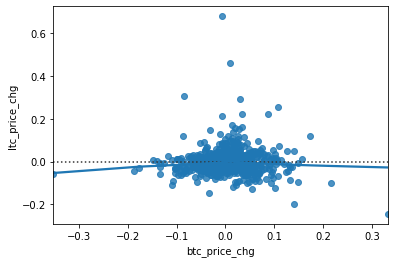

In [25]:
#residual plot.
sns.residplot(train_set_ltc['btc_price_chg'], train_set_ltc['ltc_price_chg'], lowess=True, order=1)

#### Predictions

*  About the prediction performance in test dataset, while we see some outliers, many test dataset can fall between upper and lower 95% confidence interval. 95% confidence interval is narrower than that of eth case. Also, it can fit to test data nicer than the case in eth.

In [26]:
#get upper and lower 95% of prediction.
std_ltc, upper_ltc,lower_ltc = wls_prediction_std(lr_model_ltc)

In [27]:
y_pred_ltc = lr_model_ltc.predict(test_set_ltc['btc_price_chg'])

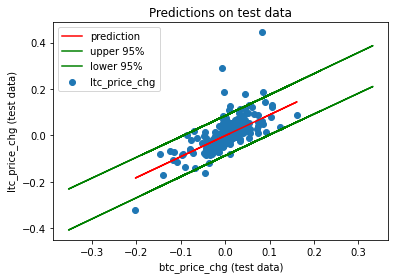

In [28]:
plt.scatter(x= 'btc_price_chg', y = 'ltc_price_chg', data=test_set_ltc)
plt.plot(test_set_ltc['btc_price_chg'], y_pred_ltc, color='red', label='prediction')
plt.plot(train_set_ltc['btc_price_chg'], upper_ltc, color='green', label='upper 95%')
plt.plot(train_set_ltc['btc_price_chg'], lower_ltc, color='green', label='lower 95%')
plt.title("Predictions on test data")
plt.legend()
plt.xlabel("btc_price_chg (test data)")
plt.ylabel("ltc_price_chg (test data)")
plt.show()